In [ ]:
import numpy as np
import os
from Utils.utilities import *
import h5py
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
#from models.cnn2d_lstm import CNN2D_LSTM_Net
from Models.cnn1d_lstm import CNN_LSTM_Net
from Models.tinny import TinyMEGNet, MEGNet

In [2]:
set_seed(42) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Use os.path.join() to create the correct file path
filepath = get_filepath()
print(f"Base filepath: {filepath}")

# Example usage for Intra-subject classification
intra_train_path = os.path.join(filepath, "Intra", "train")
intra_test_path = os.path.join(filepath, "Intra", "test")

# Load a small subset of files to test the function
# Downsample factor is set to 16 to speed up the process, CHANGE LATER!
train_raw, train_labels = load_h5_files(intra_train_path)
test_raw, test_labels = load_h5_files(intra_test_path)

train_data = normalize_meg_data(train_raw, downsample_factor=4)
test_data = normalize_meg_data(test_raw, downsample_factor=4)

Base filepath: c:\Users\marcd\Desktop\Master\Courses\Deep_Learning\Project_2\Final Project data\Final Project data


In [5]:
# Check training set size and distribution
print(f"Training samples: {len(train_data)}")
print(f"Training label distribution:")
for label in set(train_labels):
    count = train_labels.count(label)
    print(f"  {label}: {count}")

print(f"\nTest samples: {len(test_data)}")
print(f"Test label distribution:")
for label in set(test_labels):
    count = test_labels.count(label)
    print(f"  {label}: {count}")

Training samples: 32
Training label distribution:
  task_motor: 8
  task_story: 8
  rest: 8
  task_working: 8

Test samples: 8
Test label distribution:
  task_motor: 2
  task_story: 2
  rest: 2
  task_working: 2


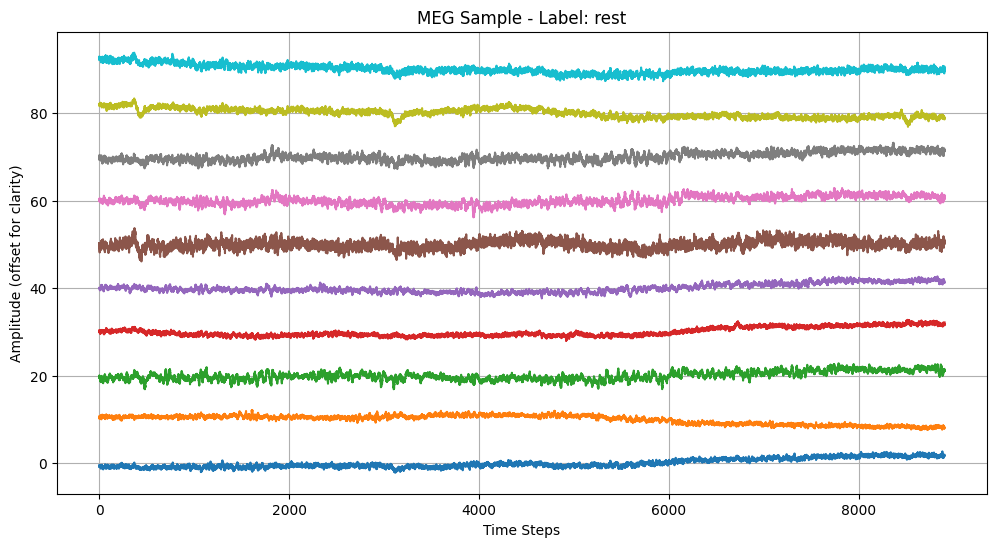

In [6]:
plot_meg_sample(train_data[0], train_labels[0])

In [7]:
# Standard class mapping for MEG tasks

LABEL_MAP = {
    'rest': 0,
    'task_motor': 1, 
    'task_story': 2,
    'task_working': 3
}

In [8]:
class CNN2D_LSTM_Net(nn.Module):
    """
    A hybrid deep learning model for MEG classification.

    Architecture:
    1. 2D CNN layers: Learn local spatiotemporal features from MEG sensor data.
    2. LSTM layer: Captures global temporal dependencies across time.
    3. Fully connected layers: Map learned features to class probabilities.
    """

    def __init__(self, num_classes=4, input_sensors=248, input_time_steps=2227,
                 lstm_hidden_size=64, num_lstm_layers=2, dropout=0.2):
        super(CNN2D_LSTM_Net, self).__init__()

        self.input_sensors = input_sensors
        self.input_time_steps = input_time_steps

        # === Step 1: 2D CNN over (sensors x time) ===
        # This block extracts local patterns in both space (sensor layout) and time.
        self.cnn = nn.Sequential(
            # Conv Layer 1: kernel, stride reduces resolution
            nn.Conv2d(1, 16, kernel_size=(3, 11), stride=(1, 3), padding=(1, 5)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 3)),  
            nn.Dropout2d(dropout),

            # Conv Layer 2
            nn.Conv2d(16, 32, kernel_size=(3, 7), stride=(1, 2), padding=(1, 3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),  
            nn.Dropout2d(dropout)
        )

        # === Auto-calculate CNN output size for LSTM ===
        # Forward a dummy input to determine the dimensions of the CNN output
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_sensors, input_time_steps)
            cnn_out = self.cnn(dummy_input)
            _, cnn_channels, reduced_sensors, reduced_time = cnn_out.shape

            # The LSTM will receive one feature vector per time step,
            # with size = channels × reduced spatial dimension
            self.lstm_input_size = cnn_channels * reduced_sensors
            self.sequence_length = reduced_time

        # === Step 2: LSTM to model temporal dynamics ===
        # Bidirectional LSTM captures temporal dependencies in both directions
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0,
            bidirectional=False
        )

        # === Step 3: Classifier (fully connected layers) ===
        # Maps LSTM output to final class scores
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size, lstm_hidden_size//2),  # bidirectional = 2×hidden
            nn.ReLU(),
            #nn.Dropout(dropout),
            nn.Linear(lstm_hidden_size//2, num_classes)
        )

        # === Print model summary ===
        print(f"2D CNN + LSTM Net initialized:")
        print(f"  - LSTM input size: {self.lstm_input_size}")
        print(f"  - Sequence length: {self.sequence_length}")
        print(f"  - Parameters: {sum(p.numel() for p in self.parameters()):,}")

    def forward(self, x):
        """
        x shape: (B, 1, sensors, time_steps)
        """
        batch_size = x.size(0)

        # === Step 1: 2D CNN ===
        x = self.cnn(x)  # Output shape: (B, channels, reduced_sensors, reduced_time)

        # === Step 2: Prepare for LSTM ===
        # Permute and flatten spatial dimensions: (B, time, features)
        x = x.permute(0, 3, 1, 2)  # -> (B, reduced_time, channels, reduced_sensors)
        x = x.contiguous().view(batch_size, self.sequence_length, -1)

        # === Step 3: LSTM ===
        lstm_out, _ = self.lstm(x)  # -> (B, time, 2 * hidden_size)

        # === Step 4: Classification using final time step ===
        x = lstm_out[:, -1, :]  # Extract features from the last time step

        return self.classifier(x)  # -> (B, num_classes)

In [9]:
CONFIG = {
    # Model hyperparameters
    "num_classes": len(LABEL_MAP),
    "input_sensors": 248,
    "input_time_steps": train_data[0].shape[1],
    "lstm_hidden_size": 32,
    "num_lstm_layers": 2,
    "dropout": 0.4,
    
    # Training hyperparameters
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "patience": 15,
    "epochs": 25,
    "batch_size": 4,
    "seed": 42,
    "n_splits": 4
}


In [10]:
model_Tiny_fn = lambda: TinyMEGNet(
    num_classes=len(LABEL_MAP),
    input_channels=248,
    input_time_steps=train_data[0].shape[1]
)

model_CNN_LSTM_fn = lambda: CNN_LSTM_Net(
    num_classes=len(LABEL_MAP),
    input_sensors=248,
    input_time_steps=train_data[0].shape[1]
)

CNN2D_LSTM_Net_fn = lambda: CNN2D_LSTM_Net(
    num_classes=CONFIG["num_classes"],
    input_sensors=CONFIG["input_sensors"],
    input_time_steps=CONFIG["input_time_steps"],
    lstm_hidden_size=CONFIG["lstm_hidden_size"],
    num_lstm_layers=CONFIG["num_lstm_layers"],
    dropout=CONFIG["dropout"],
)

In [11]:
from torchinfo import summary

W = train_data[0].shape[1]
model = CNN2D_LSTM_Net_fn()
model = model.to('cuda')

# (batch_size, channels, height, width)
summary(model, input_size=(1, 1, 248, W))

2D CNN + LSTM Net initialized:
  - LSTM input size: 7936
  - Sequence length: 247
  - Parameters: 1,040,628


Layer (type:depth-idx)                   Output Shape              Param #
CNN2D_LSTM_Net                           [1, 4]                    --
├─Sequential: 1-1                        [1, 32, 248, 247]         --
│    └─Conv2d: 2-1                       [1, 16, 248, 2969]        544
│    └─BatchNorm2d: 2-2                  [1, 16, 248, 2969]        32
│    └─ReLU: 2-3                         [1, 16, 248, 2969]        --
│    └─MaxPool2d: 2-4                    [1, 16, 248, 989]         --
│    └─Dropout2d: 2-5                    [1, 16, 248, 989]         --
│    └─Conv2d: 2-6                       [1, 32, 248, 495]         10,784
│    └─BatchNorm2d: 2-7                  [1, 32, 248, 495]         64
│    └─ReLU: 2-8                         [1, 32, 248, 495]         --
│    └─MaxPool2d: 2-9                    [1, 32, 248, 247]         --
│    └─Dropout2d: 2-10                   [1, 32, 248, 247]         --
├─LSTM: 1-2                              [1, 247, 32]              1,028,608
├─S

In [12]:
from torchviz import make_dot

x = torch.randn(1, 1, 248, W).to('cuda')

y = model(x)

make_dot(y, params=dict(model.named_parameters())).render("model_graph", format="png")


'model_graph.png'

In [13]:
# Run Experiment (cross-validation or train/val/test split)
model, train_loss, train_acc = train_on_all_data(
    all_data           =    train_data,
    all_labels         =    train_labels,
    label_map          =    LABEL_MAP,
    model_fn           =    CNN2D_LSTM_Net_fn,
    lr                 =    CONFIG["lr"],
    weight_decay       =    CONFIG["weight_decay"],
    epochs             =    CONFIG["epochs"],
    batch_size         =    CONFIG["batch_size"],
    seed               =    CONFIG["seed"]
)


  TRAINING ON FULL DATA
Total samples: 32
2D CNN + LSTM Net initialized:
  - LSTM input size: 7936
  - Sequence length: 247
  - Parameters: 1,040,628
Epoch  0: Train Loss=1.404, Train Acc=0.250
Epoch 10: Train Loss=1.371, Train Acc=0.281
Epoch 20: Train Loss=1.122, Train Acc=0.625
Epoch 24: Train Loss=0.868, Train Acc=0.688

✅ Training completed. Final training accuracy: 0.688


2D CNN + LSTM Net initialized:
  - LSTM input size: 7936
  - Sequence length: 247
  - Parameters: 1,040,628


c:\Users\marcd\Desktop\Master\Courses\Deep_Learning\Project_2\DL_2\Utils\utilities.py:650: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("be


=== Classification Report ===
              precision    recall  f1-score   support

        rest      1.000     0.500     0.667         2
  task_motor      0.200     0.500     0.286         2
  task_story      0.000     0.000     0.000         2
task_working      1.000     0.500     0.667         2

    accuracy                          0.375         8
   macro avg      0.550     0.375     0.405         8
weighted avg      0.550     0.375     0.405         8



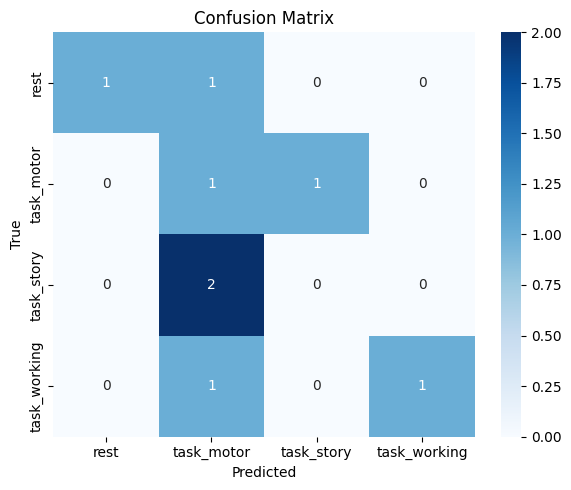


✅ Accuracy: 0.3750


In [ ]:
metrics = evaluate_on_test_set(CNN2D_LSTM_Net_fn, test_data, test_labels, LABEL_MAP)

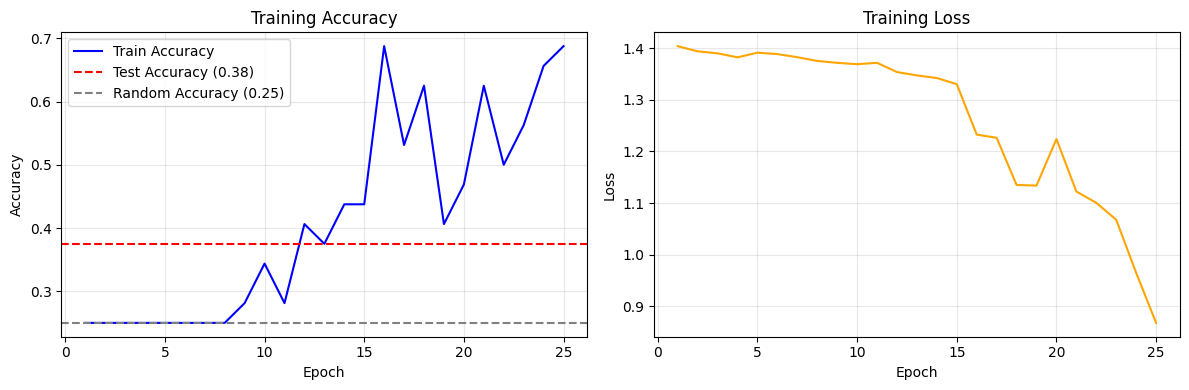

In [ ]:
plot_training_curves(train_acc, train_loss, test_acc=metrics[0])